In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
import pandas as pd
import PIL
import numpy as np 
import matplotlib.pyplot as plt
from easyimages import EasyImageList
from torch import nn
import torch
from sklearn.metrics import accuracy_score, classification_report, log_loss
import torch.nn.functional as F
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Define the new dataset

Keep in mind we are inheriting the Dataset base-class. And we have to override 2 methods:
 - \____len____
 - \____getitem____

1. load_image_and_target reads the data from the csv file and converts the image array into a PIL object - this is not mandatory but useful, as many handy functions like transform, operate on PIL.Images
2. getitem, takes a index and it should properly return for every number between (0, and len)
3. len should return the number of samples (images) in your dataset

In [2]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

class FashionMnist(Dataset):

    def __len__(self):
        return len(self.metadata_df)

    def __init__(self, metadata_df,
                 transform=None):
        
        self.metadata_df = metadata_df.copy()
        self.transform = transform
    
    def load_image_and_target(self,index):
        # .iloc is short for integer loc it returns a row of data based on its ored not index-value(if not the same)
        oneimage = self.metadata_df.iloc[index]
        image, y = PIL.Image.fromarray(
            np.array(oneimage[1:]).reshape(28, 28).astype('uint8'), 'L'), oneimage[0]
        return image, y
        
    def __getitem__(self, index):
        X, y = self.load_image_and_target(index)
        # We can transform the output images here, cast to torch data-format and/or do augmentations
        X = self.transform(X)
            
        return X, y

    def collate_func(self, batch):
        pass

    
dftrain = pd.read_csv('fashion-mnist_train.csv').sample(frac=0.1)
dftest = pd.read_csv('fashion-mnist_test.csv').sample(frac=0.1)

transform_train = transforms.Compose([transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

### our datasets supports getitem wich means we can do:

In [3]:
image, label = fmnist_train[0]
print(type(image))
print(type(label), label)

image, label = fmnist_train.load_image_and_target(0)
print(type(image), image)

<class 'torch.Tensor'>
<class 'numpy.int64'> 9
<class 'PIL.Image.Image'> <PIL.Image.Image image mode=L size=28x28 at 0x7FEB05394B38>


In [4]:
fmnist_dl = DataLoader(fmnist_train, batch_size=32, num_workers = 10)
for batch in fmnist_dl:
    break
print(batch[0].shape)
print(batch[1].shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [5]:
fmnist_dl = DataLoader(fmnist_train, batch_size=32)
batch_iterator = iter(fmnist_dl)
X, y = next(batch_iterator)

num_batches = 0
for batch in fmnist_dl:
    num_batches += 1
    #break

print(f'Found {num_batches} mini-batches.')

Found 188 mini-batches.


### Explore your dataset
Its always good to start with getting some inside about your dataset. Thats usuall much easier and less important in image datasets - but it does not mean you should not do it.

Things you should always think about working with an image dataset are:
- Check target distribiution (counts) do you see a strong imbalance?
- Check sizes of images, if not all images are of the same size you might destroy your data with wrong transformations
 

array([785])

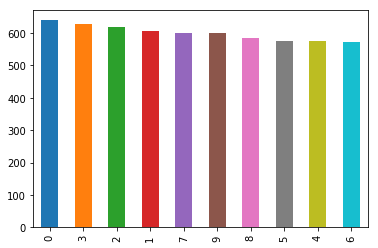

In [6]:
dftrain.label.value_counts().plot(kind='bar')

dftrain.count(axis = 1).unique()

6


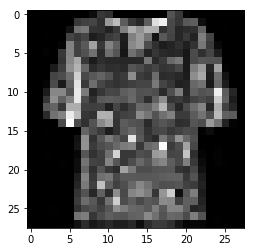

In [7]:
one_sample_image = dftrain.iloc[20].tolist()
label, image = one_sample_image[0], one_sample_image[1:]
print(label)
im = np.array(image).reshape((28, 28))
plt.imshow(im, cmap='gray')

### visualize a batch
Its always a good idea to sanity check the output of our loaders

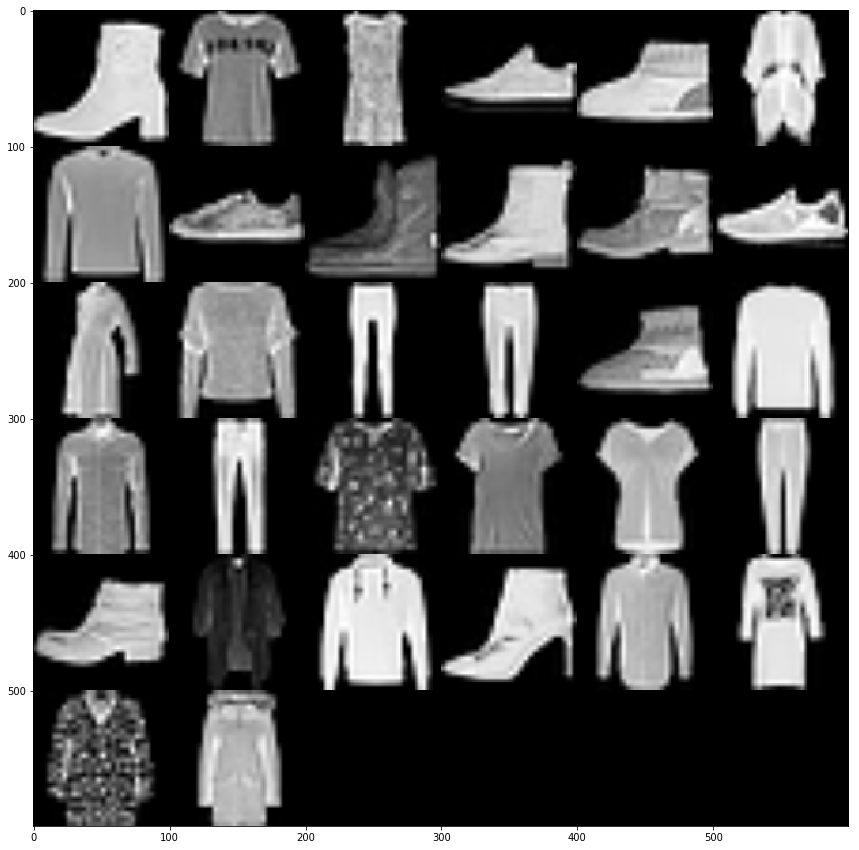

In [8]:
im = EasyImageList.from_torch_batch(X.repeat(1,3,1,1), # we need to add 3 channels to the images
                                    mean=None, std=None)
im.numpy_grid()

### Define your model architecture
As a baseline model dont  overcomplicate, either use some very simple architecture or go with something well established like resnet. There will be time to go more fancy

Here we define a model with two CONV blocks comprising of a typical:  
*Conv>BN>RELU>POOL* setting

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_of_class):
        super(SimpleCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)))
        
        self.fc = nn.Linear(7 * 7 * 32, num_of_class) # explicitly change number when changing preceding layer

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        #import pdb
        #pdb.set_trace()
        #print(out.view(out.size(0), -1).shape)
        
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
class SimpleCNN_Extended(nn.Module):
    def __init__(self, num_of_class):
        super(SimpleCNN_Extended, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout2d(p=0.60))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout2d(p=0.60))
        
        self.fc = nn.Linear(7 * 7 * 32, num_of_class) # explicitly change number when changing preceding layer

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)        
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [10]:
# Always check your model are you atleasy able to make a forward pass and shapes match your expectations?
image = torch.randn(32, 1, 28, 28)
cnn = SimpleCNN(10)
output = cnn(image)
print("input shape:")
print(image.shape)
print("output shape:")
print(output.shape)

input shape:
torch.Size([32, 1, 28, 28])
output shape:
torch.Size([32, 10])


### Define your loss function / crieterion and optimizer
Its a good idea to create some dummy data and pass it trough the cost function to make sure you uderstand what the shapes shoudl be

In case of CrossEntropyLosss We want our predictions to be of shape (BATCH_SIZE, N_CLASSES) and y_true of shape (BS) 
(Basically a vector of number that corespond to the class) 


In [11]:
yp_ = torch.randn(32, 10)
yt_ = torch.randint(10, (32,))
print(yp_.shape)
print(yt_.shape)
print(nn.CrossEntropyLoss()(yp_, yt_.long())) # one-hot encoding done automatically

torch.Size([32, 10])
torch.Size([32])
tensor(2.6984)


In [12]:
LR= 0.001
BATCH_SIZE = 128
DATASET_USAGE_SIZE = 0.05 # speeds up training, because only 5 percent of training set used

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
RESIZE = 28

cnn = SimpleCNN(10)

OPTIMIZER = 'Adam' # one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cnn.to(DEVICE)

# Create dataset loaders

dftrain = pd.read_csv('fashion-mnist_train.csv').sample(frac=DATASET_USAGE_SIZE)
dftest = pd.read_csv('fashion-mnist_test.csv').sample(frac=0.1)

transform_train = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

fmnist_train_dl = DataLoader(fmnist_train, batch_size=BATCH_SIZE)
fmnist_test_dl = DataLoader(fmnist_test, batch_size=BATCH_SIZE)

# Lets try to use the criterion with dummy data
yp = torch.randn(BATCH_SIZE, 10)
yt = torch.randint(10, (BATCH_SIZE,))
criterion(yp, yt.long())

len(fmnist_train_dl)
len(dftrain)

3000

In [13]:
def evaluate_model(model, test_loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in test_loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            pred = cnn(X)
            collect_results.append(pred.sigmoid().detach().cpu().numpy()) # should be softmax
            collect_target.append(y) 
    
        preds_proba = np.concatenate(collect_results)
        preds = preds_proba.argmax(axis=1)
        
        targets = np.concatenate(collect_target)
        
        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(ac))
            #print(classification_report(targets, preds))
        model.train()
        
        return ll, acc
    
    
            
collect_metrics = []
collect_loss = []
for epoch in range(50):
    lossacc = 0
    for i, batch in enumerate(fmnist_train_dl):
        optimizer.zero_grad()
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = cnn(X)
        
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()  
        collect_loss.append(float(loss.detach().cpu().numpy()))  
        
    lltest, acctest = evaluate_model(cnn, fmnist_test_dl)
    lltrain, acctrain = evaluate_model(cnn, fmnist_train_dl)
    collect_metrics.append([lltest, lltrain, acctest, acctrain])
    print("test: loss: {}  acc: {}".format(lltest, acctest))
    print("train: loss: {}  acc: {}".format(lltrain, acctrain))



test: loss: 1.8384479966163636  acc: 0.728
train: loss: 1.8374043224652608  acc: 0.751
test: loss: 1.2674321985244752  acc: 0.774
train: loss: 1.254098450432221  acc: 0.7996666666666666
test: loss: 1.1405022428929805  acc: 0.799
train: loss: 1.1191420760502417  acc: 0.845
test: loss: 1.092822900891304  acc: 0.816
train: loss: 1.0658314694017172  acc: 0.862
test: loss: 1.0570643062591554  acc: 0.823
train: loss: 1.0250438430309297  acc: 0.8746666666666667
test: loss: 1.0314072427004575  acc: 0.831
train: loss: 0.9949880064005653  acc: 0.8853333333333333
test: loss: 1.0043373846411705  acc: 0.829
train: loss: 0.9631076593026519  acc: 0.8956666666666667
test: loss: 0.9803925965875387  acc: 0.833
train: loss: 0.9334948680251837  acc: 0.907
test: loss: 0.9538818016201258  acc: 0.836
train: loss: 0.8992114901362608  acc: 0.9153333333333333
test: loss: 0.9340115458816289  acc: 0.839
train: loss: 0.8713322489159182  acc: 0.9246666666666666
test: loss: 0.9146882584542037  acc: 0.842
train: loss

<Figure size 432x288 with 0 Axes>

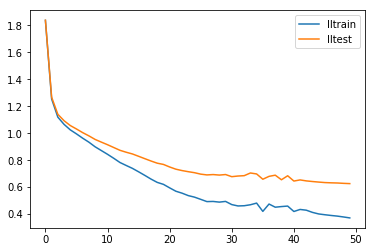

<Figure size 432x288 with 0 Axes>

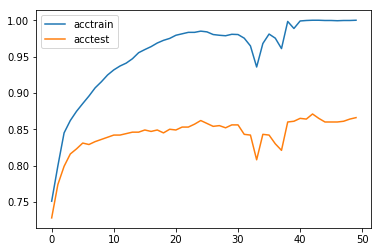

In [15]:
columns = ['lltest', 'lltrain', 'acctest', 'acctrain']
metrics_df = pd.DataFrame(collect_metrics, columns=columns)
plt.figure()
metrics_df[['lltrain', 'lltest']].plot()
plt.figure()
metrics_df[['acctrain', 'acctest']].plot()

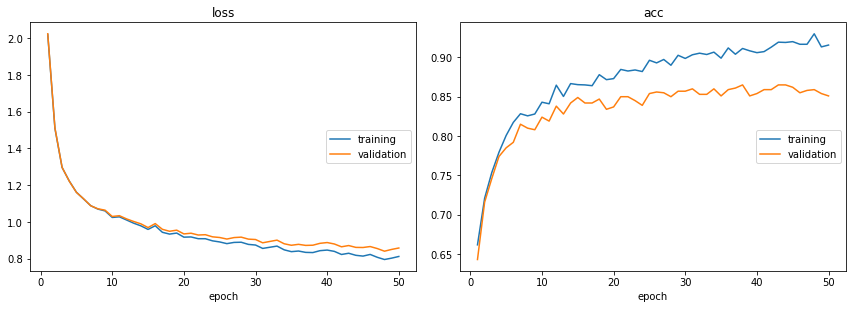

loss:
training   (min:    0.795, max:    2.020, cur:    0.812)
validation (min:    0.840, max:    2.024, cur:    0.858)

acc:
training   (min:    0.662, max:    0.930, cur:    0.916)
validation (min:    0.643, max:    0.865, cur:    0.851)


In [16]:
from livelossplot import PlotLosses

def evaluate_model_extended(model, test_loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in test_loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            pred = cnn_extended(X)
            collect_results.append(pred.sigmoid().detach().cpu().numpy()) # should be softmax
            collect_target.append(y) 
    
        preds_proba = np.concatenate(collect_results)
        preds = preds_proba.argmax(axis=1)
        
        targets = np.concatenate(collect_target)
        
        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(ac))
            #print(classification_report(targets, preds))
        model.train()
        
        return ll, acc


liveloss = PlotLosses()

LR_extended= 0.001
RESIZE = 28
BATCH_SIZE_extended = 128
DATASET_USAGE_SIZE_extended = 0.05 # speeds up training, because only 5 percent of training set used

cnn_extended = SimpleCNN_Extended(10)

OPTIMIZER_extended = 'Adam'
optimizer_extended = getattr(torch.optim, OPTIMIZER_extended)(cnn_extended.parameters(), lr=0.001)
criterion_extended = nn.CrossEntropyLoss()

cnn_extended.to(DEVICE)

# Create dataset loaders
dftrain_extended = pd.read_csv('fashion-mnist_train.csv').sample(frac=DATASET_USAGE_SIZE_extended)
dftest_extended = pd.read_csv('fashion-mnist_test.csv').sample(frac=0.1)

transform_train_extended = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_train_extended = FashionMnist(dftrain_extended, transform=transform_train_extended)

transform_test_extended = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_test_extended = FashionMnist(dftest_extended, transform=transform_test_extended)

fmnist_train_dl_extended = DataLoader(fmnist_train_extended, batch_size=BATCH_SIZE_extended)
fmnist_test_dl_extended = DataLoader(fmnist_test_extended, batch_size=BATCH_SIZE_extended)

collect_metrics_extended = []
collect_loss_extended = []

for epoch in range(50):
    logs = {}
    lossacc = 0
    for i, batch in enumerate(fmnist_train_dl_extended):
        logs = {}
        optimizer_extended.zero_grad()
        X, y = batch
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = cnn_extended(X)
        
        loss = criterion_extended(y_pred, y)
        loss.backward()
        optimizer_extended.step()  
        collect_loss_extended.append(float(loss.detach().cpu().numpy()))
        
        #lltest_extended, acctest_extended = evaluate_model(cnn_extended, fmnist_test_dl_extended)
        #lltrain_extended, acctrain_extended = evaluate_model(cnn_extended, fmnist_train_dl_extended)
        #collect_metrics_extended.append([lltest_extended, lltrain_extended, acctest_extended, acctrain_extended])
        #print("test: loss: {}  acc: {}".format(lltest_extended, acctest_extended))
        #print("train: loss: {}  acc: {}".format(lltrain_extended, acctrain_extended))
        #logs['val_loss'] = lltest_extended
        #logs['loss'] = lltrain_extended
        #logs['val_acc'] = acctest_extended
        #logs['acc'] = acctrain_extended
        #liveloss.update(logs)
        #liveloss.draw()
        
    lltest_extended, acctest_extended = evaluate_model_extended(cnn_extended, fmnist_test_dl_extended)
    lltrain_extended, acctrain_extended = evaluate_model_extended(cnn_extended, fmnist_train_dl_extended)
    collect_metrics_extended.append([lltest_extended, lltrain_extended, acctest_extended, acctrain_extended])
    #print("test: loss: {}  acc: {}".format(lltest_extended, acctest_extended))
    #print("train: loss: {}  acc: {}".format(lltrain_extended, acctrain_extended))
    logs['val_loss'] = lltest_extended
    logs['loss'] = lltrain_extended
    logs['val_acc'] = acctest_extended
    logs['acc'] = acctrain_extended
    liveloss.update(logs)
    liveloss.draw()

### Questions/Exercises
- why do we use torch.no_grad():
- Try changing the kernel size of the CNN's what is your intuition should we use a smaller or bigger kernel?
- Get the output of the first cnn, look at its shape and how it looks
- Add dropout to the network, where does it make sense? To put it?


1.) no_grad(): no backprop/gradient calculation is done, results in far better performance (no training)


2.) maybe smaller since kernel is relatively big compared to image size, but since kernels should be odd in width and height there is no smaller option


3.) see below


4.) after the pooling of the two first layers, not in output layer

In [27]:
print(X.shape)
print(y.shape)
print(y_pred.shape)

torch.Size([56, 1, 28, 28])
torch.Size([56])
torch.Size([56, 10])


# Crude LR-finder implementation

0
tensor(0.0005, grad_fn=<NllLossBackward>)
100
tensor(2.3010, grad_fn=<NllLossBackward>)
200
tensor(1.2083, grad_fn=<NllLossBackward>)
300
tensor(1.2458, grad_fn=<NllLossBackward>)
400
tensor(1.2238, grad_fn=<NllLossBackward>)
500
tensor(2.4994, grad_fn=<NllLossBackward>)


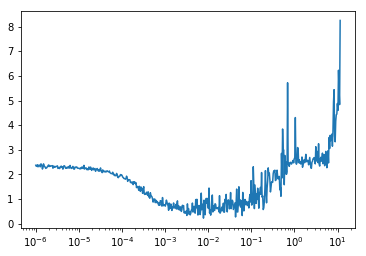

In [29]:
dftrain = pd.read_csv('fashion-mnist_train.csv').sample(frac=1)
fmnist_train = FashionMnist(dftrain, transform=transform_train)
data_loader = DataLoader(fmnist_train, batch_size=32)



INITIAL_LR = 10e-7
losses = []
lrs = []
cnn = SimpleCNN(10)#.cuda()
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)

for param_group in optimizer.param_groups:
    param_group['lr'] = INITIAL_LR
    

for i, batch in enumerate(data_loader):
    if i % 100 == 0: 
        print(i)
        print(loss)
        
    optimizer.zero_grad()
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    y_pred = cnn(X)

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if loss > 10:
        break

    current_lr = lr = optimizer.param_groups[0]['lr']
    losses.append(loss)
    lrs.append(current_lr)

    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr * 1.03
        
    if i == 1000:
        break


    
df = pd.DataFrame([l.detach().cpu().numpy() for l in losses])
df['lrs'] = lrs
ax = plt.plot(df['lrs'], df[0])
plt.xscale('log')

LR between 10-4 and 10-3 would be best.